In [1]:
import glob
import os
import pandas as pd
import re
import numpy as np
import string
from sklearn.preprocessing import minmax_scale
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from pprint import pprint
import seaborn as sns
from statsmodels.tsa.stattools import adfuller  
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose  
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf   

In [2]:
# Reading and normalizing csv containing the btc historial prices

btc_df = pd.read_csv("Bitcoin Historical Data - Investing.com.csv", usecols = ['Date','Price'])
btc_df['Date'] = pd.to_datetime(btc_df['Date'])
btc_df['Date'] = btc_df['Date'].dt.normalize()
btc_df = btc_df.reset_index().set_index('Date')
btc_df = btc_df.drop(['index'], axis=1)
btc_df['Price'] = btc_df['Price'].str.replace(',', '')
btc_df['Price'] = btc_df['Price'].astype('float64')
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 2021-06-26 to 2020-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   361 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


/home/prbpedro/Development/python_envs/tcc_puc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Box plot para preço do bitcoin')

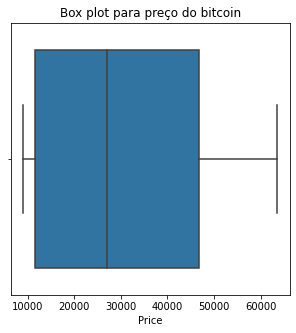

In [3]:
#verificando se existem outliers
plt.figure(figsize=(5, 5))
g = sns.boxplot(btc_df['Price'])  #realiza o plot através da biblioteca seaborn
g.set_title('Box plot para preço do bitcoin')

Text(0, 0.5, 'Preço')

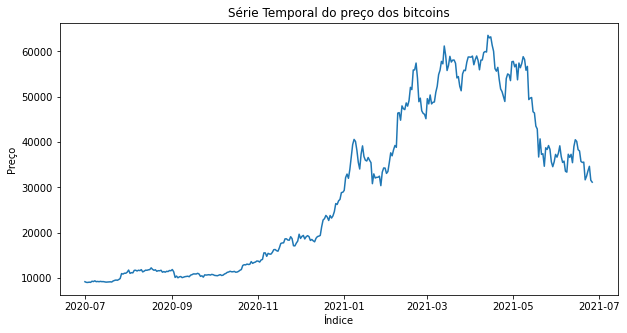

In [4]:
#plotando o gráfico da variação do preço no período
plt.figure(figsize=(10, 5))
g = sns.lineplot(x=btc_df.index,y=btc_df['Price'])
g.set_title('Série Temporal do preço dos bitcoins')
g.set_xlabel('Índice')
g.set_ylabel('Preço')

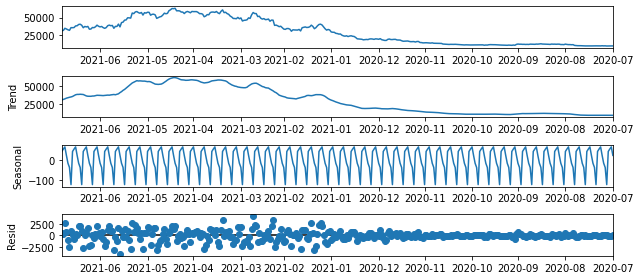

ADF P-valor: 0.8844454842278063


In [5]:
#testando a estacionariedade da série temporal

#realizando a construção do modelo de decomposição da série temporal
#aplica o modelo de decomposição aditiva
decomposicao_aditiva = seasonal_decompose(btc_df, model='aditive',extrapolate_trend='freq')   

#realiza o plot da decomposição
rcParams['figure.figsize'] = 9, 4
fig=decomposicao_aditiva.plot()  #realiza o plot da decomposição
plt.show()


#aplica o teste adf
resultado_ADF = adfuller(btc_df['Price'].values, autolag='AIC')
#para o teste ADF a hipótese nula é que existe, pelo menos, uma raiz negativa 
#na série temporal (série é não-estacionária)

# com o p-valor maior que 0,05 a hipótese nula não é rejeitada
# > 0.05 estacionária
# < 0.05 não estacionária
print('ADF P-valor:',resultado_ADF[1] )

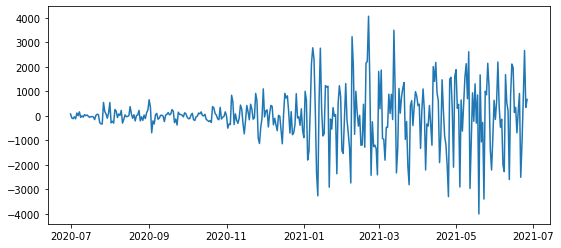

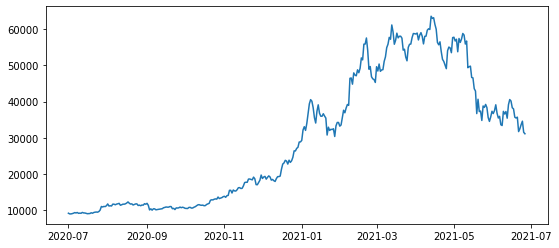

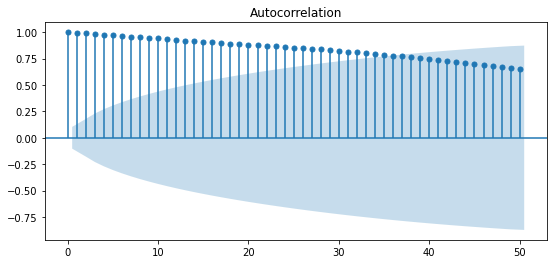

In [6]:
#retirando a tendência
detrended = decomposicao_aditiva.resid + decomposicao_aditiva.seasonal
plt.plot(detrended)
plt.show()  

#retirando a sazonalidade
deseasonalized = decomposicao_aditiva.trend + decomposicao_aditiva.resid
plt.plot(deseasonalized)
plt.show()  

#realizando a análise de autocorrelação nos dados
#aplica a autocorrelação entre os dados
plot_acf(btc_df, lags=50)  
#mostra uma correlação significativa com 14 lags
plt.show()  


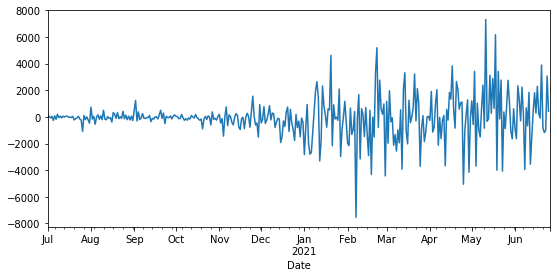

p-valor: 0.000003


In [7]:
#Transformando a série em estacionária
#aplica o primeiro "Shift" (derivada para tempo discreto)
btc_df['Price'] = btc_df['Price'] - btc_df['Price'].shift(1)

btc_df['Price'].plot()
plt.show()  

#Conferindo se agora está estacionária
X_diff = btc_df['Price'].dropna().values
resultado_primeira_diff = adfuller(X_diff)

#pvalor 0.000003 rejeita a hipótese nula
print('p-valor: %f' % resultado_primeira_diff[1]) 

In [9]:
# Merging the btc historical price data with the sentimental analisys data

df = pd.read_csv("btc_em_sentimental_analysis.csv", index_col='Date')
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)
btc_df.index = btc_df.index.tz_localize(None)
merged = pd.merge(df, btc_df, on = ['Date'], how = 'outer')

In [10]:
# Creating final csv file with Date, Score and Price columns

merged['Score'] = merged['Score'].fillna(0)
merged['Score'] = pd.to_numeric(merged['Score'])
merged['PositiveScore'] = merged['PositiveScore'].fillna(0)
merged['PositiveScore'] = pd.to_numeric(merged['PositiveScore'])
merged['NeutralScore'] = merged['NeutralScore'].fillna(0)
merged['NeutralScore'] = pd.to_numeric(merged['NeutralScore'])
merged['NegativeScore'] = merged['NegativeScore'].fillna(0)
merged['NegativeScore'] = pd.to_numeric(merged['NegativeScore'])
merged['Price'] = pd.to_numeric(merged['Price'])
merged.to_csv('btc_value_em_tweets_sentimental_score.csv')

In [11]:
merged.head()

,Score,PositiveScore,NeutralScore,NegativeScore,Price
Date,,,,,
2021-06-13,0.8689,0.226,0.774,0.000,-1506.5
2021-06-04,-0.4215,0.000,0.517,0.483,1331.3
2021-05-22,0.4404,0.304,0.552,0.144,2768.6
2021-05-11,0.4404,0.438,0.562,0.000,7311.5
2021-05-07,0.5859,0.444,0.556,0.000,-1502.9
